# Axial stressed beam

We consider a simple beam stressed by a traction load F at both sides.

<img src="axial-stressed-beam.png" width="250">

The geometry is supposed to be deterministic: the diameter D is fixed to 
$$
D=0.02 \textrm{ (m)}.
$$

By definition, the yield stress is the load divided by the surface. Since the surface is $\pi D^2/4$, the stress is:
$$
S = \frac{F}{\pi D^2/4}.
$$
It is considered that failure occurs when the beam plastifies, i.e. when the axial stress gets bigger than the yield stress:
$$
R - \frac{F}{\pi D^2/4} \leq 0
$$
where $R$ is the strength.
 
Therefore, the limit state function $G$ is: 
$$
G(R,F) = R - \frac{F}{\pi D^2/4},
$$
for any $R,F\in\mathbb{R}$.
The values of the parameter $D$ implies:
$$
D^2/4 = 10^{-4},
$$
which leads to the equation:
$$
G(R,F) = R - \frac{F}{10^{-4} \pi}.
$$

We consider the following distribution functions.

| Variable | Distribution |
|--|--|
| R | LogNormal($\mu_R=3\times 10^6$, $\sigma_R=3\times 10^5$) [Pa] |
| F | Normal($\mu_F=750$, $\sigma_F=50$) [N] |

where $\mu_R=E(R)$ and $\sigma_R^2=V(R)$ are the mean and the variance of $R$.

The failure probability is: 
\begin{align}
P_f &= \text{Prob}(G(R,F) \leq 0).
\end{align}

The exact $P_f$ is 
$$
P_f = 0.02920.
$$

## Definition of the model

In [1]:
import openturns as ot
import numpy as np

The dimension of the problem.

In [2]:
dim = 2

Analytical model definition:

In [3]:
limitState = ot.SymbolicFunction(['R', 'F'], ['R-F/(1.e-4 * pi_)'])

Test of the limit state function.

In [4]:
x = [3.e6, 750.]
print('x=', x)
print('G(x)=', limitState(x))

x= [3000000.0, 750.0]
G(x)= [612676]


Stochastic model definition. Create a first marginal : LogNormal distribution 1D, parameterized by its mean and standard deviation.

In [5]:
R = ot.LogNormalMuSigma(3.e6, 3.e5, 0.0).getDistribution()
R.setName('Yield strength')
R.setDescription('R')

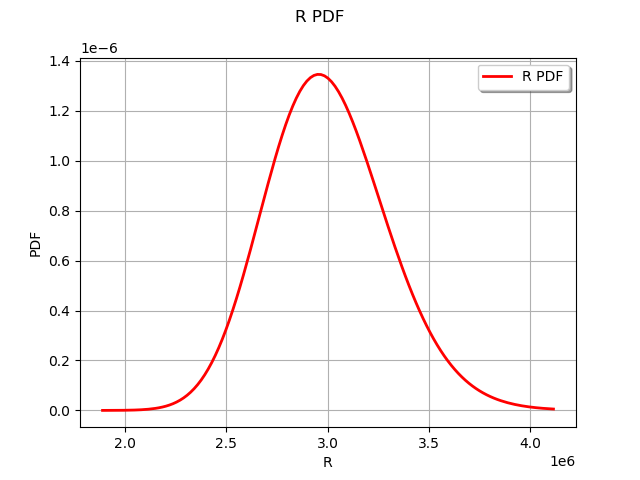

In [6]:
R.drawPDF()

Create a second marginal : Normal distribution 1D.

In [7]:
F = ot.Normal(750., 50.)
F.setName('Traction_load')
F.setDescription('F')

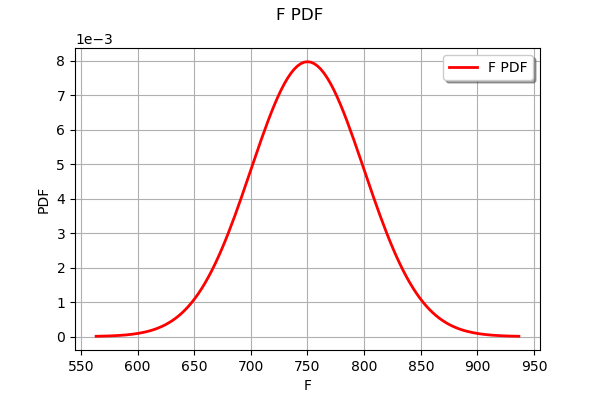

In [8]:
F.drawPDF()

Create an independent copula.

In [9]:
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

In [10]:
myDistribution = ot.ComposedDistribution([R, F], aCopula)
myDistribution.setName('myDist')

We create a RandomVector from the Distribution.

In [11]:
vect = ot.RandomVector(myDistribution)

We create a composite random vector.

In [12]:
myfunction = ot.CompositeRandomVector(limitState, vect)

Perform the computation based on the arithmetic of distributions.

In [13]:
D = 0.02

In [14]:
G = R-F/(D**2/4 * np.pi)

In [15]:
G.computeCDF(0.)

0.02919819462483051

## Distribution of the output

Plot the distribution of the output.

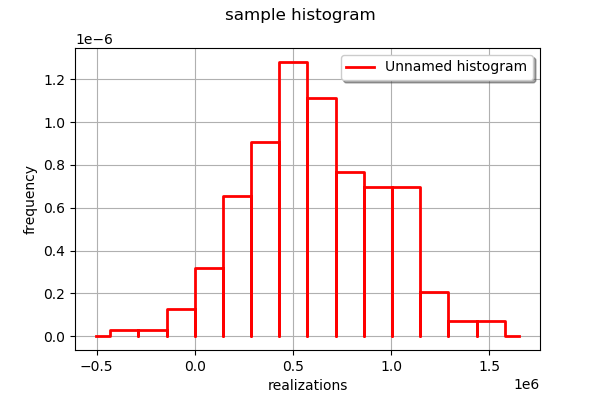

In [16]:
sampleSize = 500
sampleG = myfunction.getSample(sampleSize)
ot.VisualTest_DrawHistogram(sampleG)

## Estimate the probability with Monte-Carlo

In [17]:
# We create an Event from this RandomVector
myEvent = ot.Event(myfunction, ot.Less(), 0.0)

In [18]:
# Using Monte Carlo simulations
cv = 0.05
NbSim = 100000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(NbSim)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoMC.run()

MonteCarlo result= probabilityEstimate=3.025813e-02 varianceEstimate=2.288277e-06 standard deviation=1.51e-03 coefficient of variation=5.00e-02 confidenceLength(0.95)=5.93e-03 outerSampling=12823 blockSize=1
Number of executed iterations = 12823
Number of calls to the limit state = 12823
Pf =  0.030258129922794978
CV = 0.04999334672427731


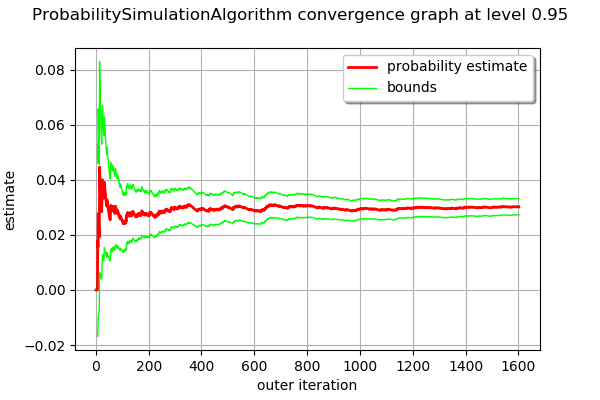

In [19]:
# Results:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
print('MonteCarlo result=', result)
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoMC.drawProbabilityConvergence()

Using FORM analysis.

Number of calls to the limit state = 98
Pf = 0.029982785582315003


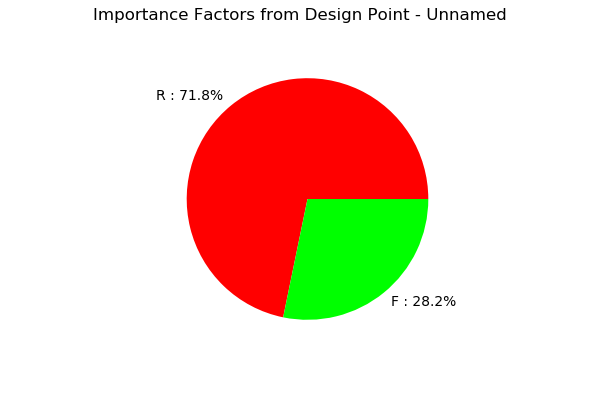

In [20]:
# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
myCobyla.setMaximumEvaluationNumber(100)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoFORM.run()

# Results:
result = algoFORM.getResult()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf =', result.getEventProbability())

# Graphical result output
result.drawImportanceFactors()

Using Directional sampling.

Number of executed iterations = 525
Number of calls to the limit state = 9672
Pf =  0.028140280682849687
CV = 0.04991794870214791


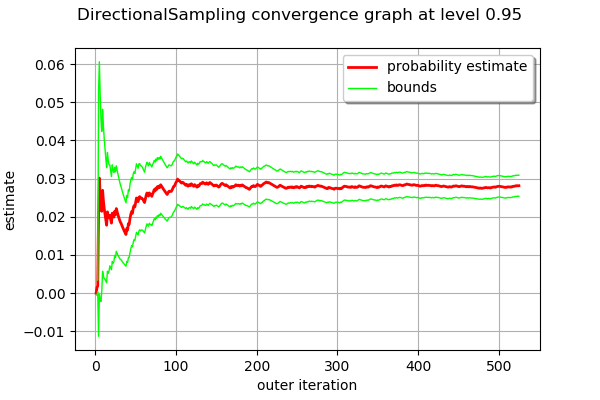

In [21]:
# Resolution options:
cv = 0.05
NbSim = int(1e5)

algoDS = ot.DirectionalSampling(myEvent)
algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoDS.run()

# Results:
result = algoDS.getResult()
probability = result.getProbabilityEstimate()
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoDS.drawProbabilityConvergence()

## Appendix : derivation of the probability

The failure probability is: 
\begin{align}
P_f &= \text{Prob}(R-S \leq 0) \\
&= \int_{r-s \leq 0} f_{R, S}(r, s)drds
\end{align}
where $f_{R, S}$ is the probability distribution function of the random vector $(R,S)$.
If R and S are independent, then: 
$$
f_{R, S}(r, s) = f_R(r) f_S(s)
$$
for any $r,s\in\mathbb{R}$, 
where $f_S$ is the probability distribution function of the random variable $S$ and $f_R$ is the probability distribution function of the random variable $R$.
Therefore,
\begin{align}
P_f 
&= \int_{r-s \leq 0} f_R(r) f_S(s) drds \\
&= \int_{-\infty}^{+\infty} \left(\int_{r \leq s} f_R(r) dr \right) f_S(s) ds \\
&= \int_{-\infty}^{+\infty}f_S(s)F_R(s)ds \\
\end{align}
where $F_R$ is the cumulative distribution function of the random variable $R$.